##### Introduction to BERT and Transformers Library

In [1]:
from transformers import pipeline

C:\Users\srika\anaconda3\Lib\site-packages\transformers\utils\generic.py:260: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(


In [2]:
### analyzing sentiment using transformer pipeline

In [3]:
classifier = pipeline("sentiment-analysis")

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


In [4]:
result = classifier("I hate you")[0]
print(f"label: {result['label']}, with score: {round(result['score'], 4)}")

label: NEGATIVE, with score: 0.9991


In [5]:
result = classifier("I don't hate you, but who doesn't love your face")[0]
print(f"label: {result['label']}, with score: {round(result['score'], 4)}")

label: NEGATIVE, with score: 0.9825


### Text Generation

In [6]:
text_generator = pipeline("text-generation")

No model was supplied, defaulted to gpt2 and revision 6c0e608 (https://huggingface.co/gpt2).
Using a pipeline without specifying a model name and revision in production is not recommended.


In [7]:
print(text_generator("As far as love is concerned, I love to ", max_length=30, do_sample=False))

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


[{'generated_text': 'As far as love is concerned, I love to \xa0have a good time. I love to have a good time. I love to have a'}]


### Creating Named Entity Recognition (NER)

In [8]:
ner_pipe = pipeline("ner")

No model was supplied, defaulted to dbmdz/bert-large-cased-finetuned-conll03-english and revision f2482bf (https://huggingface.co/dbmdz/bert-large-cased-finetuned-conll03-english).
Using a pipeline without specifying a model name and revision in production is not recommended.
Some weights of the model checkpoint at dbmdz/bert-large-cased-finetuned-conll03-english were not used when initializing BertForTokenClassification: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [9]:
sequence = """Hugging Face Inc. is a company based in New york city. Manhattan bridge is visible from the window."""

In [10]:
for entity in ner_pipe(sequence):
    print(entity)

{'entity': 'I-ORG', 'score': 0.99954754, 'index': 1, 'word': 'Hu', 'start': 0, 'end': 2}
{'entity': 'I-ORG', 'score': 0.990086, 'index': 2, 'word': '##gging', 'start': 2, 'end': 7}
{'entity': 'I-ORG', 'score': 0.9977804, 'index': 3, 'word': 'Face', 'start': 8, 'end': 12}
{'entity': 'I-ORG', 'score': 0.99955183, 'index': 4, 'word': 'Inc', 'start': 13, 'end': 16}
{'entity': 'I-LOC', 'score': 0.99441695, 'index': 11, 'word': 'New', 'start': 40, 'end': 43}
{'entity': 'I-LOC', 'score': 0.866851, 'index': 12, 'word': 'yo', 'start': 44, 'end': 46}
{'entity': 'I-LOC', 'score': 0.9872278, 'index': 13, 'word': '##rk', 'start': 46, 'end': 48}
{'entity': 'I-LOC', 'score': 0.9989699, 'index': 16, 'word': 'Manhattan', 'start': 55, 'end': 64}


### Generating Masked Language Model Using a Model and a Tokenizer

 ### Masked Langauge Modeling
- Import the necessary modules from the transformers library and torch
- Load the pre-trained tokenizer and model
- Define the input sequence with a masked token
- Tokenize the input sequence and convert to tensors
- Find the index of the masked token and generate token predictions using the model
- Get the indices of the top 5 predicted tokens and print them in the sequence
- Load the pre-trained tokenizer and model
- Define the input sequence with a masked token
- Tokenize the input sequence and convert to tensors
- Find the index of the masked token and generate token predictions using the model
- Get the indices of the top 5 predicted tokens and print them in the sequence
- Print the top 5 predicted tokens in the masked position

In [11]:
from transformers import AutoModelForMaskedLM, AutoTokenizer
import torch

In [12]:
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-cased")
model = AutoModelForMaskedLM.from_pretrained("distilbert-base-cased")

In [13]:
sequence = (
    "Distilled models are smaller than the models they mimic. Using them instead of the large "
    f"versions would help {tokenizer.mask_token} our carbon footprint."
)

In [14]:
inputs = tokenizer(sequence, return_tensors="pt")
mask_token_index = torch.where(inputs["input_ids"] == tokenizer.mask_token_id)[1]

token_logits = model(**inputs).logits
mask_token_logits = token_logits[0, mask_token_index, :]

top_5_tokens = torch.topk(mask_token_logits, 5, dim=1).indices[0].tolist()

In [15]:
for token in top_5_tokens:
    print(sequence.replace(tokenizer.mask_token, tokenizer.decode([token])))

Distilled models are smaller than the models they mimic. Using them instead of the large versions would help reduce our carbon footprint.
Distilled models are smaller than the models they mimic. Using them instead of the large versions would help increase our carbon footprint.
Distilled models are smaller than the models they mimic. Using them instead of the large versions would help decrease our carbon footprint.
Distilled models are smaller than the models they mimic. Using them instead of the large versions would help offset our carbon footprint.
Distilled models are smaller than the models they mimic. Using them instead of the large versions would help improve our carbon footprint.


### Text Classification using BERT

In [16]:
import pandas as pd
import torch
import numpy as np
from transformers import BertTokenizer, BertModel
from torch import nn
from torch.optim import Adam
from tqdm import tqdm

In [17]:
df = pd.read_csv("bbc-text.csv")
df.head()

,category,text
0,tech,tv future in the hands of viewers with home th...
1,business,worldcom boss left books alone former worldc...
2,sport,tigers wary of farrell gamble leicester say ...
3,sport,yeading face newcastle in fa cup premiership s...
4,entertainment,ocean s twelve raids box office ocean s twelve...


<Axes: xlabel='category'>

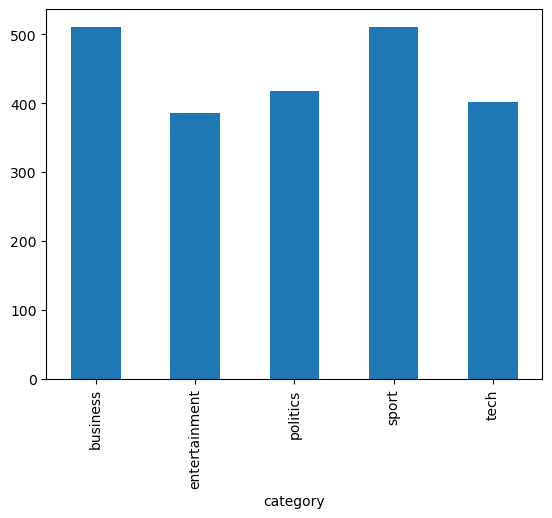

In [18]:
df.groupby(['category']).size().plot.bar()

In [19]:
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')
labels = {'business':0,
          'entertainment':1,
          'sport':2,
          'tech':3,
          'politics':4
          }

In [20]:
class Dataset(torch.utils.data.Dataset):

    def __init__(self, df):

        self.labels = [labels[label] for label in df['category']]
        self.texts = [tokenizer(text,
                               padding='max_length', max_length = 512, truncation=True,
                                return_tensors="pt") for text in df['text']]

    def classes(self):
        return self.labels

    def __len__(self):
        return len(self.labels)

    def get_batch_labels(self, idx):
        # Fetch a batch of labels
        return np.array(self.labels[idx])

    def get_batch_texts(self, idx):
        # Fetch a batch of inputs
        return self.texts[idx]

    def __getitem__(self, idx):

        batch_texts = self.get_batch_texts(idx)
        batch_y = self.get_batch_labels(idx)

        return batch_texts, batch_y

In [21]:
class BertClassifier(nn.Module):

    def __init__(self, dropout=0.5):

        super(BertClassifier, self).__init__()

        self.bert = BertModel.from_pretrained('bert-base-cased')
        self.dropout = nn.Dropout(dropout)
        self.linear = nn.Linear(768, 5)
        self.relu = nn.ReLU()

    def forward(self, input_id, mask):

        _, pooled_output = self.bert(input_ids= input_id, attention_mask=mask,return_dict=False)
        dropout_output = self.dropout(pooled_output)
        linear_output = self.linear(dropout_output)
        final_layer = self.relu(linear_output)

        return final_layer

In [22]:
def train(model, train_data, val_data, learning_rate, epochs):

    train, val = Dataset(train_data), Dataset(val_data)

    train_dataloader = torch.utils.data.DataLoader(train, batch_size=2, shuffle=True)
    val_dataloader = torch.utils.data.DataLoader(val, batch_size=2)

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    criterion = nn.CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr= learning_rate)

    if use_cuda:

            model = model.cuda()
            criterion = criterion.cuda()

    for epoch_num in range(epochs):

            total_acc_train = 0
            total_loss_train = 0

            for train_input, train_label in tqdm(train_dataloader):

                train_label = train_label.to(device)
                mask = train_input['attention_mask'].to(device)
                input_id = train_input['input_ids'].squeeze(1).to(device)

                output = model(input_id, mask)

                batch_loss = criterion(output, train_label)
                total_loss_train += batch_loss.item()

                acc = (output.argmax(dim=1) == train_label).sum().item()
                total_acc_train += acc

                model.zero_grad()
                batch_loss.backward()
                optimizer.step()

            total_acc_val = 0
            total_loss_val = 0

            with torch.no_grad():

                for val_input, val_label in val_dataloader:

                    val_label = val_label.to(device)
                    mask = val_input['attention_mask'].to(device)
                    input_id = val_input['input_ids'].squeeze(1).to(device)

                    output = model(input_id, mask)

                    batch_loss = criterion(output, val_label)
                    total_loss_val += batch_loss.item()

                    acc = (output.argmax(dim=1) == val_label).sum().item()
                    total_acc_val += acc

            print(
                f'Epochs: {epoch_num + 1} | Train Loss: {total_loss_train / len(train_data): .3f} | Train Accuracy: {total_acc_train / len(train_data): .3f} | Val Loss: {total_loss_val / len(val_data): .3f} | Val Accuracy: {total_acc_val / len(val_data): .3f}')


In [23]:
def evaluate(model, test_data):

    test = Dataset(test_data)

    test_dataloader = torch.utils.data.DataLoader(test, batch_size=2)

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    if use_cuda:

        model = model.cuda()

    total_acc_test = 0
    with torch.no_grad():

        for test_input, test_label in test_dataloader:

              test_label = test_label.to(device)
              mask = test_input['attention_mask'].to(device)
              input_id = test_input['input_ids'].squeeze(1).to(device)

              output = model(input_id, mask)

              acc = (output.argmax(dim=1) == test_label).sum().item()
              total_acc_test += acc

    print(f'Test Accuracy: {total_acc_test / len(test_data): .3f}')

In [24]:
np.random.seed(112)
df_train, df_val, df_test = np.split(df.sample(frac=1, random_state=42),
                                     [int(.8*len(df)), int(.9*len(df))])

print(len(df_train),len(df_val), len(df_test))

1780 222 223


In [25]:
EPOCHS = 5
model = BertClassifier()
LR = 1e-6

In [ ]:
train(model, df_train, df_val, LR, EPOCHS)

In [ ]:
evaluate(model, df_test)